In [404]:
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

df = pd.read_csv('lam_data_processed.csv')
df.head()

,Aika,N
0,2020-01-01 00:00:00,12650.0
1,2020-01-01 01:00:00,11666.0
2,2020-01-01 02:00:00,8620.0
3,2020-01-01 03:00:00,6654.0
4,2020-01-01 04:00:00,5784.0


In [405]:
# first slice of data, where the training data is all data before March and test data are first 2 weeks of March
train1 = df[df['Aika'] < '2020-03-01 00:00:00']
train2 = df[df['Aika'] < '2020-03-15 00:00:00']
train3 = df[df['Aika'] < '2020-04-01 00:00:00']
train4 = df[df['Aika'] < '2020-04-15 00:00:00']
train5 = df[df['Aika'] < '2020-05-01 00:00:00']
train6 = df[df['Aika'] < '2020-05-15 00:00:00']
train_data_unprocessed = [train1, train2, train3, train4, train5, train6]

In [406]:
def pre_modify_traindata(data_list) :
    clean = []

    for data in data_list :
        clean_df = data.copy()
        clean_df['order'] = clean_df.apply(lambda row: len(clean_df) - row.name, axis=1)
        clean_df['traffic_future'] = clean_df['N'].shift(336) # 14 vuorokautta * 24t => 336t
        clean_df = clean_df.dropna()
        clean.append(clean_df)
    
    return clean

train_datas = pre_modify_traindata(train_data_unprocessed)

In [407]:
train_datas[0].head()

,Aika,N,order,traffic_future
336,2020-01-15 00:00:00,1620.0,1104,12650.0
337,2020-01-15 01:00:00,1127.0,1103,11666.0
338,2020-01-15 02:00:00,1037.0,1102,8620.0
339,2020-01-15 03:00:00,997.0,1101,6654.0
340,2020-01-15 04:00:00,2034.0,1100,5784.0


In [408]:
# test-data's always the next 2 weeks of real data
test1 = df[(df['Aika'] >= '2020-03-01 00:00:00') & (df['Aika'] < '2020-03-15 00:00:00')]
test2 = df[(df['Aika'] >= '2020-03-15 00:00:00') & (df['Aika'] < '2020-04-01 00:00:00')]
test3 = df[(df['Aika'] >= '2020-04-01 00:00:00') & (df['Aika'] < '2020-04-15 00:00:00')]
test4 = df[(df['Aika'] >= '2020-04-15 00:00:00') & (df['Aika'] < '2020-05-01 00:00:00')]
test5 = df[(df['Aika'] >= '2020-05-01 00:00:00') & (df['Aika'] < '2020-05-15 00:00:00')]
test6 = df[(df['Aika'] >= '2020-05-15 00:00:00') & (df['Aika'] < '2020-06-01 00:00:00')]
test_data_unprocessed = [test1, test2, test3, test4, test5, test6]

In [409]:
def modify_testdata(list_testdata) :
    clean = []
    
    for data in list_testdata :
        clean_test = data.copy()
        clean_test['order'] = clean_test.apply(lambda row: len(clean_test) + clean_test.index.values[0]
                                           - row.name, axis=1)
        clean.append(clean_test)
        
    return clean

test_datas = modify_testdata(test_data_unprocessed)

In [410]:
test_datas[0].head()

,Aika,N,order
1440,2020-03-01 00:00:00,4182.0,336
1441,2020-03-01 01:00:00,3008.0,335
1442,2020-03-01 02:00:00,2416.0,334
1443,2020-03-01 03:00:00,2021.0,333
1444,2020-03-01 04:00:00,2091.0,332


In [411]:
def prediction(train_data, test_data) :
    """
    This function finishes the preprocessing, does the modeling, checks the validity and 
    preps data for visualisation
    """
    # rest of the preprocessing + modelling of train-data
    X = np.array(train_data[['order', 'N']]) # input-muuttujat
    y = np.array(train_data['traffic_future']) # output-muuttuja
    model = linear_model.LinearRegression()
    model.fit(X, y)
    train_data['prediction'] = model.predict(X)

    # rest of the preprocessing + predicting test-data
    X_test = np.array(test_data[['order', 'N']])
    test_data['prediction'] = model.predict(X_test)

    # Validation 
    from sklearn import metrics
    
    # MAE and MSE in train-data
    mae = mean_absolute_error(train_data['traffic_future'], train_data['prediction'])
    mse = metrics.mean_squared_error(train_data['traffic_future'], train_data['prediction'])
    rmse = np.sqrt(metrics.mean_squared_error(train_data['traffic_future'], train_data['prediction']))
    train_validation = [mae, rmse]
    
    print("Train-data:\nMAE: %.f" % mae)
    print("MSE: %.f" % mse)
    print("RMSE: %.f" % rmse)

    # MAE and MSE in test-data
    mae_t = mean_absolute_error(test_data['N'], test_data['prediction'])
    mse_t = metrics.mean_squared_error(test_data['N'], test_data['prediction'])
    rmse_t = np.sqrt(metrics.mean_squared_error(test_data['N'], test_data['prediction']))
    test_validation = [mae_t, rmse_t]
    
    print("\nTest-data:\nMAE: %.f" % mae_t)
    print("MSE: %.f" % mse_t)
    print("RMSE: %.f" % rmse_t)
    
    model_coefs = [model.coef_, model.intercept_]
    print("\nModel coefficients are \n", model.coef_, model.intercept_ )
    
    return [train_data, test_data, train_validation, test_validation, model_coefs]

In [412]:
# first prediction : train-data mid Jan to end of Feb. Test-data first 2 weeks of March.
prediction1 = prediction(train_datas[0], test_datas[0])
print("\ntrain_head:", prediction1[0].head())
print("\ntest_head:", prediction1[1].head())

Train-data:
MAE: 982
MSE: 5847104
RMSE: 2418

Test-data:
MAE: 361
MSE: 180396
RMSE: 425

Model coefficients are 
 [-1.27930006  0.968962  ] 880.2135698342845

train_head:                     Aika       N  order  traffic_future   prediction
336  2020-01-15 00:00:00  1620.0   1104         12650.0  1037.584750
337  2020-01-15 01:00:00  1127.0   1103         11666.0   561.165784
338  2020-01-15 02:00:00  1037.0   1102          8620.0   475.238504
339  2020-01-15 03:00:00   997.0   1101          6654.0   437.759324
340  2020-01-15 04:00:00  2034.0   1100          5784.0  1443.852219

test_head:                      Aika       N  order   prediction
1440  2020-03-01 00:00:00  4182.0    336  4502.567841
1441  2020-03-01 01:00:00  3008.0    335  3366.285751
1442  2020-03-01 02:00:00  2416.0    334  2793.939547
1443  2020-03-01 03:00:00  2021.0    333  2412.478856
1444  2020-03-01 04:00:00  2091.0    332  2481.585496


In [413]:
# Second prediction : train-data mid-Jan to Mid-March. Test-data last 2 weeks of March.
prediction2 = prediction(train_datas[1], test_datas[1])
print("\ntrain_head:", prediction2[0].head())
print("\ntest_head:", prediction2[1].head())

Train-data:
MAE: 975
MSE: 5021656
RMSE: 2241

Test-data:
MAE: 532
MSE: 347498
RMSE: 589

Model coefficients are 
 [-1.16774737  0.97582259] 1050.6536909966944

train_head:                     Aika       N  order  traffic_future   prediction
336  2020-01-15 00:00:00  1620.0   1440         12650.0   949.930071
337  2020-01-15 01:00:00  1127.0   1439         11666.0   470.017284
338  2020-01-15 02:00:00  1037.0   1438          8620.0   383.360999
339  2020-01-15 03:00:00   997.0   1437          6654.0   345.495843
340  2020-01-15 04:00:00  2034.0   1436          5784.0  1358.591611

test_head:                      Aika       N  order   prediction
1776  2020-03-15 00:00:00  3235.0    408  3730.998829
1777  2020-03-15 01:00:00  2418.0    407  2934.919524
1778  2020-03-15 02:00:00  1925.0    406  2455.006737
1779  2020-03-15 03:00:00  1714.0    405  2250.275919
1780  2020-03-15 04:00:00  1635.0    404  2174.353682


In [414]:
# Third prediction : train-data mid-Jan to end of March. Test-data first 2 weeks of April.
prediction3 = prediction(train_datas[2], test_datas[2])
print("\ntrain_head:", prediction3[0].head())
print("\ntest_head:", prediction3[1].head())

Train-data:
MAE: 1771
MSE: 7922823
RMSE: 2815

Test-data:
MAE: 3069
MSE: 9508615
RMSE: 3084

Model coefficients are 
 [-3.07801224  1.00908225] 3492.9911463012686

train_head:                     Aika       N  order  traffic_future   prediction
336  2020-01-15 00:00:00  1620.0   1848         12650.0  -560.462221
337  2020-01-15 01:00:00  1127.0   1847         11666.0 -1054.861759
338  2020-01-15 02:00:00  1037.0   1846          8620.0 -1142.601150
339  2020-01-15 03:00:00   997.0   1845          6654.0 -1179.886428
340  2020-01-15 04:00:00  2034.0   1844          5784.0  -130.390120

test_head:                      Aika       N  order   prediction
2184  2020-04-01 00:00:00  1406.0    336  3877.548681
2185  2020-04-01 01:00:00   942.0    335  3412.412528
2186  2020-04-01 02:00:00   795.0    334  3267.155450
2187  2020-04-01 03:00:00   806.0    333  3281.333367
2188  2020-04-01 04:00:00  1658.0    332  4144.149458


In [415]:
# Fourth prediction : train-data mid-Jan to mid-April. Test-data last 2 weeks of April.
prediction4 = prediction(train_datas[3], test_datas[3])
print("\ntrain_head:", prediction4[0].head())
print("\ntest_head:", prediction4[1].head())

Train-data:
MAE: 1759
MSE: 8741038
RMSE: 2957

Test-data:
MAE: 2608
MSE: 6870558
RMSE: 2621

Model coefficients are 
 [-2.00107263  1.01233527] 2834.7623353258823

train_head:                     Aika       N  order  traffic_future  prediction
336  2020-01-15 00:00:00  1620.0   2184         12650.0  104.402839
337  2020-01-15 01:00:00  1127.0   2183         11666.0 -392.677376
338  2020-01-15 02:00:00  1037.0   2182          8620.0 -481.786477
339  2020-01-15 03:00:00   997.0   2181          6654.0 -520.278815
340  2020-01-15 04:00:00  2034.0   2180          5784.0  531.513930

test_head:                      Aika       N  order   prediction
2520  2020-04-15 00:00:00  1384.0    384  3467.422455
2521  2020-04-15 01:00:00   948.0    383  3028.045351
2522  2020-04-15 02:00:00   772.0    382  2851.875416
2523  2020-04-15 03:00:00   799.0    381  2881.209541
2524  2020-04-15 04:00:00  1575.0    380  3668.782782


In [416]:
# Fifth prediction : train-data mid-Jan to end of April. Test-data first 2 weeks of May.
prediction5 = prediction(train_datas[4], test_datas[4])
print("\ntrain_head:", prediction5[0].head())
print("\ntest_head:", prediction5[1].head())

Train-data:
MAE: 1819
MSE: 11486386
RMSE: 3389

Test-data:
MAE: 667
MSE: 478595
RMSE: 692

Model coefficients are 
 [-0.22861335  0.98106793] 956.8786413670259

train_head:                     Aika       N  order  traffic_future   prediction
336  2020-01-15 00:00:00  1620.0   2568         12650.0  1959.129590
337  2020-01-15 01:00:00  1127.0   2567         11666.0  1475.691716
338  2020-01-15 02:00:00  1037.0   2566          8620.0  1387.624216
339  2020-01-15 03:00:00   997.0   2565          6654.0  1348.610112
340  2020-01-15 04:00:00  2034.0   2564          5784.0  2366.206165

test_head:                      Aika       N  order   prediction
2904  2020-05-01 00:00:00  3017.0    336  3839.946486
2905  2020-05-01 01:00:00  2205.0    335  3043.547944
2906  2020-05-01 02:00:00  1676.0    334  2524.791625
2907  2020-05-01 03:00:00  1285.0    333  2141.422679
2908  2020-05-01 04:00:00  1181.0    332  2039.620228


In [417]:
# Sixth prediction : train-data mid-Jan to mid-May. Test-data last 2 weeks of May.
prediction6 = prediction(train_datas[5], test_datas[5])
print("\ntrain_head:", prediction6[0].head())
print("\ntest_head:", prediction6[1].head())

Train-data:
MAE: 1801
MSE: 11125692
RMSE: 3336

Test-data:
MAE: 297
MSE: 135848
RMSE: 369

Model coefficients are 
 [0.04634873 0.97337391] 611.4008301486374

train_head:                     Aika       N  order  traffic_future   prediction
336  2020-01-15 00:00:00  1620.0   2904         12650.0  2322.863285
337  2020-01-15 01:00:00  1127.0   2903         11666.0  1842.943598
338  2020-01-15 02:00:00  1037.0   2902          8620.0  1755.293597
339  2020-01-15 03:00:00   997.0   2901          6654.0  1716.312292
340  2020-01-15 04:00:00  2034.0   2900          5784.0  2725.654690

test_head:                      Aika       N  order   prediction
3240  2020-05-15 00:00:00  1845.0    408  2426.185980
3241  2020-05-15 01:00:00  1196.0    407  1794.419963
3242  2020-05-15 02:00:00   911.0    406  1516.962049
3243  2020-05-15 03:00:00   927.0    405  1532.489683
3244  2020-05-15 04:00:00  1840.0    404  2421.133716


                 mae         rmse
1/March   360.617124   424.730844
2/March   532.254037   589.489512
3/April  3068.904147  3083.604271
4/April  2608.219973  2621.174947
5/May     666.661560   691.805321
6/May     297.178524   368.575414


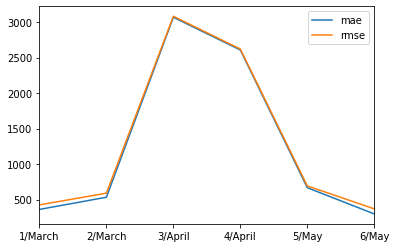

In [418]:
# Visualising MAE and RMSE to see changes in validity. 
lists = [prediction1[3], prediction2[3], prediction3[3], prediction4[3], prediction5[3], prediction6[3]]
df_validation = pd.concat([pd.Series(x) for x in lists], axis=1).T
df_validation.columns = ['mae', 'rmse']
df_validation.index = ['1/March', '2/March','3/April', '4/April', '5/May', '6/May']
print(df_validation)

df_validation.plot()
plt.legend()
plt.savefig('validation.jpg')

In [419]:
def extracting_needed_columns(data, test_data) :
    '''
    Extracts the Aika and prediction -columns from train and test-datasets and combines them in one df, 
    and lastly renames the prediction-column to show which prediction it is.
    '''
    df_train = data[['Aika', 'prediction']]
    df_test = test_data[['Aika', 'prediction']]
    df = pd.concat([df_train, df_test])
    df.rename({'prediction':'pred'})
    return df

vis_df1 = extracting_needed_columns(prediction1[0], prediction1[1])
vis_df2 = extracting_needed_columns(prediction2[0], prediction2[1])
vis_df3 = extracting_needed_columns(prediction3[0], prediction3[1])
vis_df4 = extracting_needed_columns(prediction4[0], prediction4[1])
vis_df5 = extracting_needed_columns(prediction5[0], prediction5[1])
vis_df6 = extracting_needed_columns(prediction6[0], prediction6[1])
vis_datas = [vis_df1, vis_df2, vis_df3, vis_df4, vis_df5, vis_df6]

In [420]:
def combining_to_mainframe(df_to_join, list_of_dfs) :
    '''
    combines the needed column from list_of_dfs to main df using join. 
    '''
    count = 0
    
    for data in list_of_dfs :
        count += 1
        df_to_join = df_to_join.merge(data, on='Aika', how='left', suffixes=('', count))
    
    return df_to_join
    
visualising = combining_to_mainframe(df, vis_datas)  

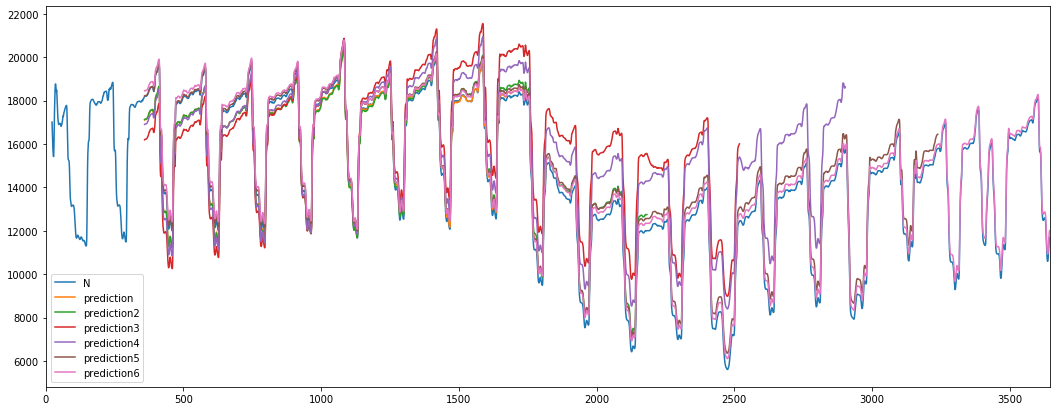

In [421]:
visualising.rolling(24).mean().plot(figsize=(18,7))
plt.savefig('whole.jpg')

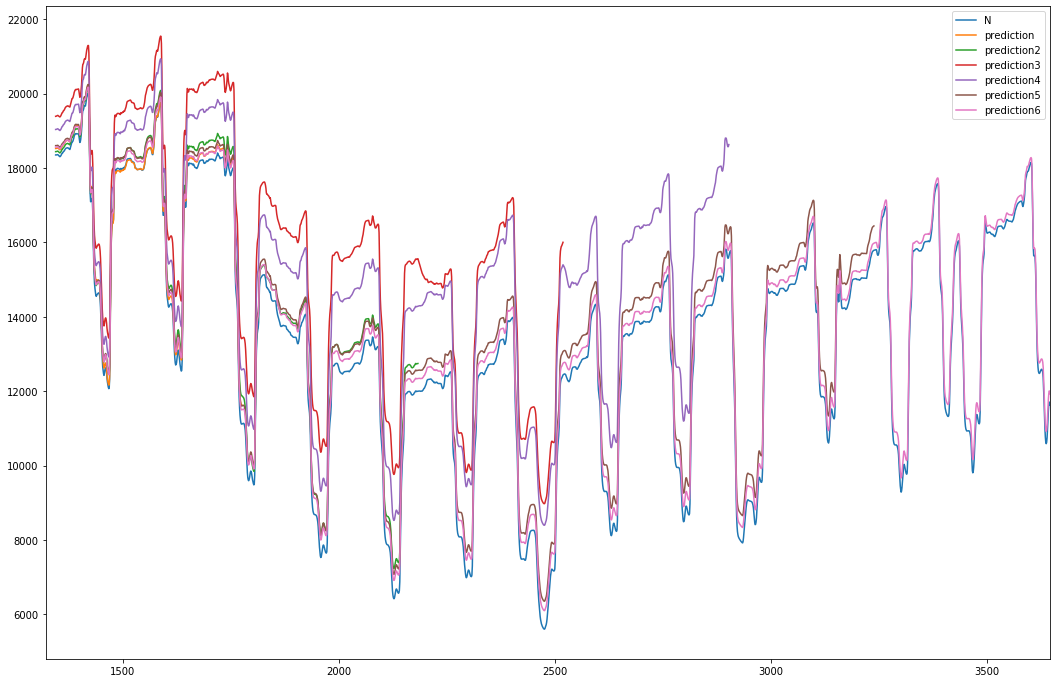

In [422]:
visualising2 = visualising[visualising['Aika'] > '2020-02-25 00:00:00']
visualising2.rolling(24).mean().plot(figsize=(18,12))
plt.savefig('predictions_all.jpg')

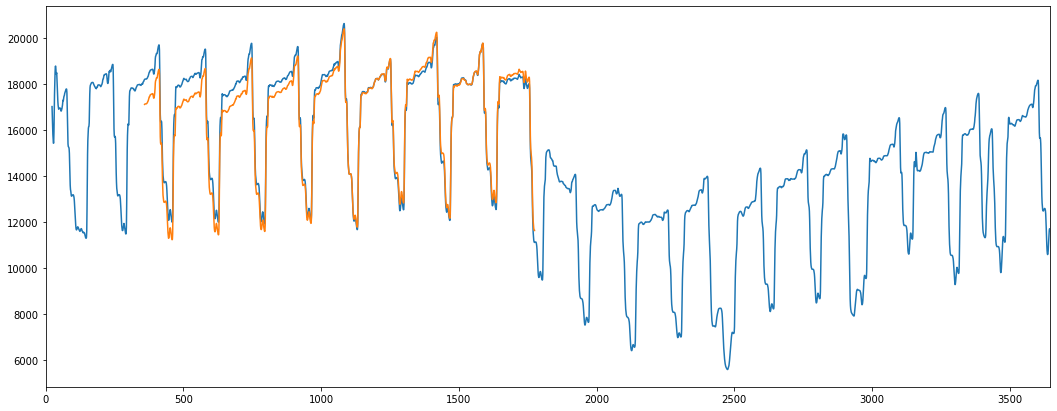

In [423]:
# first prediction
visualising['N'].rolling(24).mean().plot(figsize=(18,7))
visualising['prediction'].rolling(24).mean().plot(figsize=(18,7))
plt.savefig('prediction1.jpg')

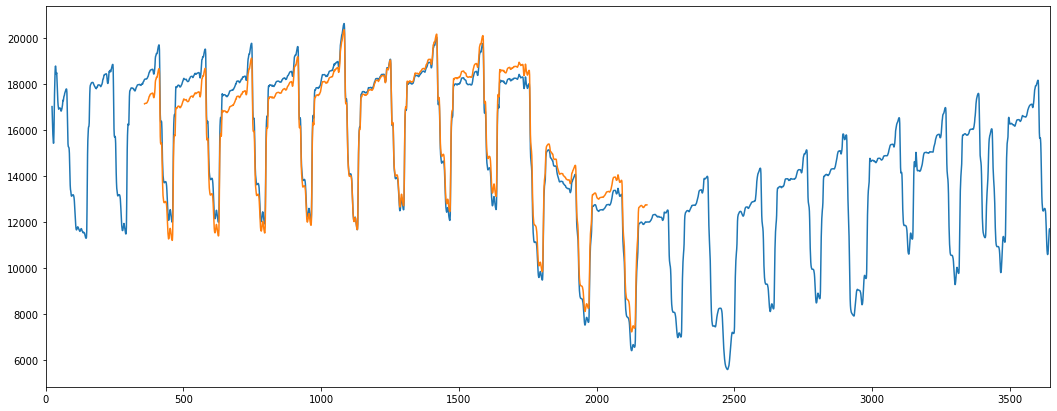

In [424]:
# second prediction
visualising['N'].rolling(24).mean().plot(figsize=(18,7))
visualising['prediction2'].rolling(24).mean().plot(figsize=(18,7))
plt.savefig('prediction2.jpg')

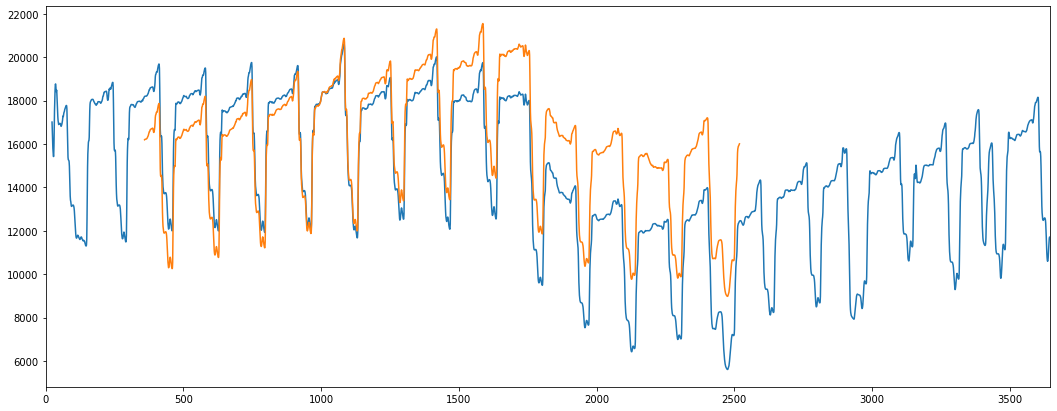

In [425]:
# third prediction
visualising['N'].rolling(24).mean().plot(figsize=(18,7))
visualising['prediction3'].rolling(24).mean().plot(figsize=(18,7))
plt.savefig('prediction3.jpg')

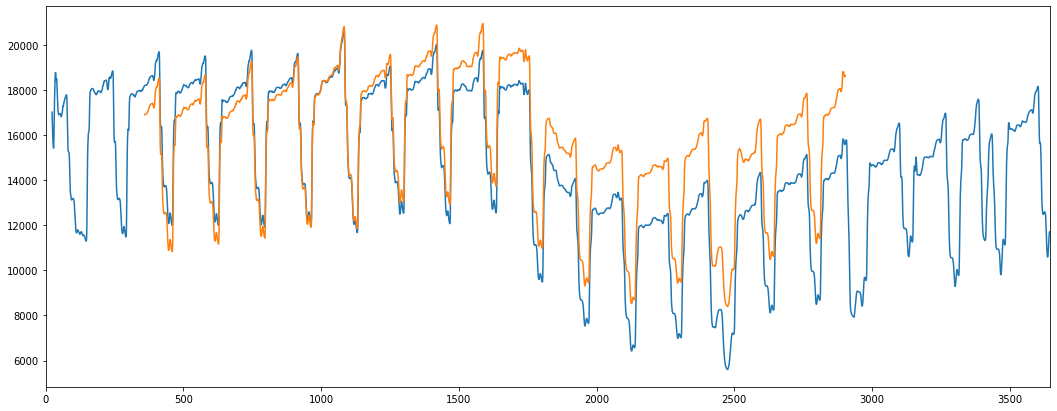

In [426]:
# fourth prediction
visualising['N'].rolling(24).mean().plot(figsize=(18,7))
visualising['prediction4'].rolling(24).mean().plot(figsize=(18,7))
plt.savefig('prediction4.jpg')

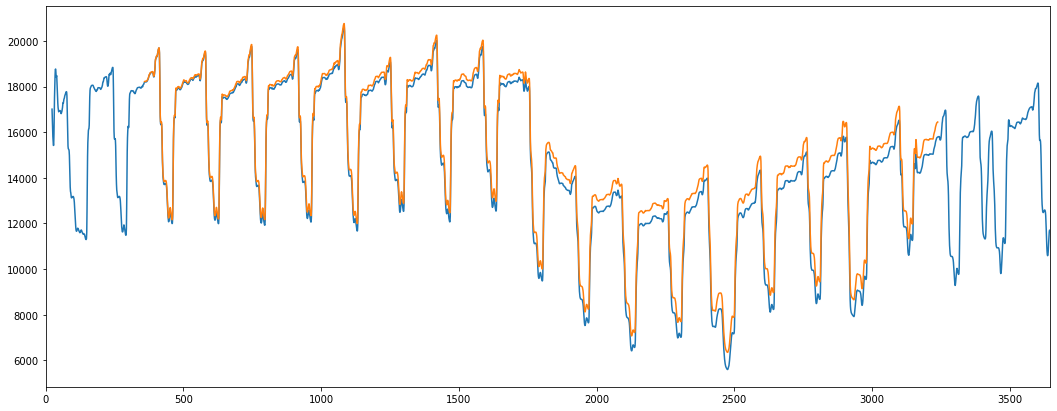

In [427]:
# fifth prediction
visualising['N'].rolling(24).mean().plot(figsize=(18,7))
visualising['prediction5'].rolling(24).mean().plot(figsize=(18,7))
plt.savefig('prediction5.jpg')

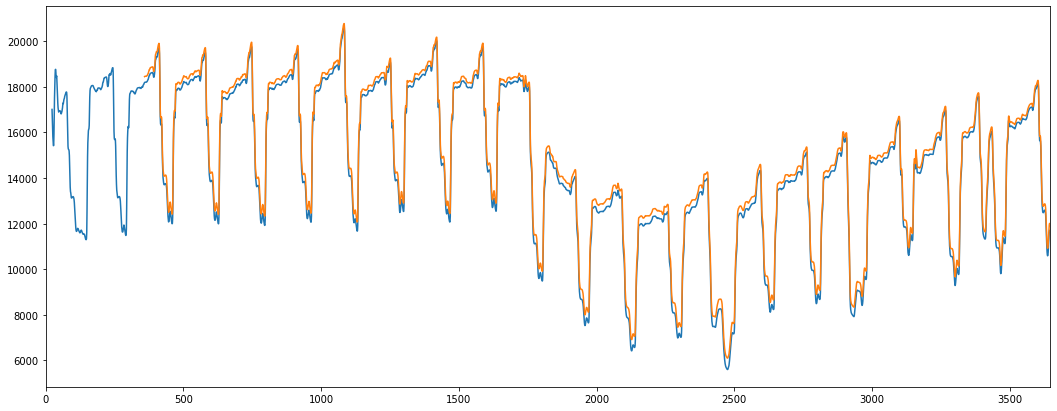

In [428]:
# sixth prediction
visualising['N'].rolling(24).mean().plot(figsize=(18,7))
visualising['prediction6'].rolling(24).mean().plot(figsize=(18,7))
plt.savefig('prediction6.jpg')